In [1]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

BASE = "/home/hep/an1522/dark_tridents_wspace/outputs/inference"

MODELS = {
    "DM-CNN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_mpid"),
        "sig_dir": os.path.join(BASE, "run3_signal_mpid"),
    },
    "ResNet18-GN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_resnet18_gn"),
        "sig_dir": os.path.join(BASE, "run3_signal_resnet18_gn"),
    },
    "ResNet18-BN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_resnet18_bn"),
        "sig_dir": os.path.join(BASE, "run3_signal_resnet18_bn"),
    },
    "ResNet34-GN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_resnet34_gn"),
        "sig_dir": os.path.join(BASE, "run3_signal_resnet34_gn"),
    },
    "ResNet34-BN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_resnet34_bn"),
        "sig_dir": os.path.join(BASE, "run3_signal_resnet34_bn"),
    },
}

SCORE_COL = "signal_score"


In [2]:
def load_scores_csv(csv_path, score_col="signal_score"):
    df = pd.read_csv(csv_path)
    s = pd.to_numeric(df[score_col], errors="coerce").to_numpy()
    s = s[np.isfinite(s)]
    s = s[s >= 0.0]   # drop placeholders like -999999.9
    return s

def load_background_scores(bkg_dir, score_col="signal_score"):
    bkg_dir = Path(bkg_dir)
    files = sorted(bkg_dir.glob("*_scores.csv"))
    if not files:
        raise FileNotFoundError(f"No *_scores.csv found in {bkg_dir}")
    all_scores = [load_scores_csv(f, score_col=score_col) for f in files]
    return np.concatenate(all_scores)

def compute_roc_auc(bkg_scores, sig_scores):
    y_true = np.r_[np.zeros(len(bkg_scores)), np.ones(len(sig_scores))].astype(int)
    y_score = np.r_[bkg_scores, sig_scores].astype(float)
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=False)
    return fpr, tpr, auc(fpr, tpr)

def parse_ratio_mass_from_name(fname):
    # expects something like run1_dt_ratio_0.6_ma_0.01_pi0_larcv_cropped_scores.csv
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_", fname)
    if not m:
        return None, None
    return float(m.group(1)), float(m.group(2))


In [3]:
bkg_scores = {}
for model_name, cfg in MODELS.items():
    bkg_scores[model_name] = load_background_scores(cfg["bkg_dir"], score_col=SCORE_COL)
    print(model_name, "bkg events:", len(bkg_scores[model_name]))


DM-CNN bkg events: 29374
ResNet18-GN bkg events: 29374
ResNet18-BN bkg events: 29374
ResNet34-GN bkg events: 29374
ResNet34-BN bkg events: 29374


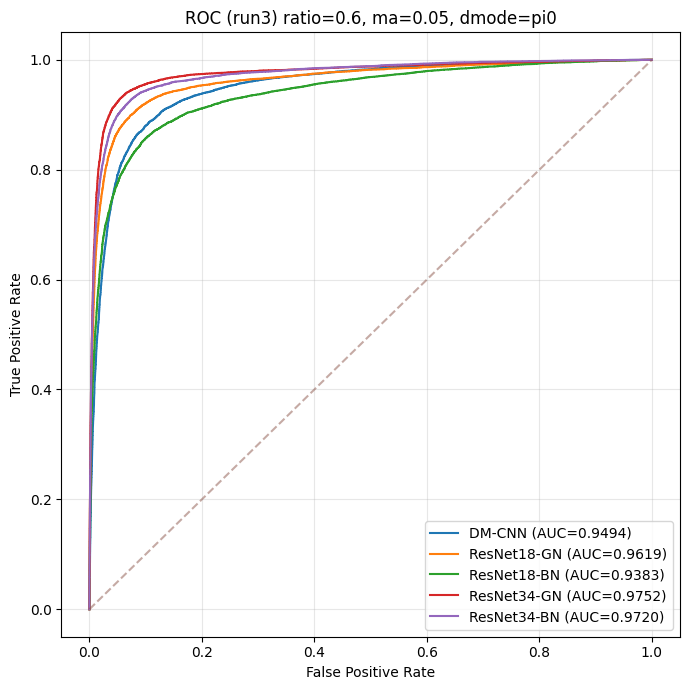

In [4]:
# parse ratio, mass, dmode from filename
def parse_ratio_mass_dmode(fname):
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

TARGET_MASS = 0.05
RATIO = 0.6   # or 2.0
DMODE = "pi0" # "pi0" or "eta"

# collect signal files for DM-CNN folder
sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# find the DM-CNN signal file matching ratio + mass + dmode
f_dmcnn = None
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if (abs(ratio - RATIO) < 1e-9) and (abs(mass - TARGET_MASS) < 1e-9) and (dmode == DMODE):
        f_dmcnn = f
        break

if f_dmcnn is None:
    raise FileNotFoundError(f"No signal file found for ratio={RATIO}, ma={TARGET_MASS}, dmode={DMODE}")

plt.figure(figsize=(7, 7))

for model_name, cfg in MODELS.items():
    f_sig = Path(cfg["sig_dir"]) / f_dmcnn.name
    if not f_sig.exists():
        print(f"[skip] missing for {model_name}: {f_sig.name}")
        continue

    sig = load_scores_csv(f_sig, score_col=SCORE_COL)
    fpr, tpr, auc_val = compute_roc_auc(bkg_scores[model_name], sig)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC (run3) ratio={RATIO}, ma={TARGET_MASS}, dmode={DMODE}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

out_dir = "/home/hep/an1522/dark_tridents_wspace/outputs/roc_auc"
os.makedirs(out_dir, exist_ok=True)

plt.savefig(
    os.path.join(out_dir, f"ROC_ratio_{RATIO}_ma_{TARGET_MASS}_{DMODE}_run3.png"),
    dpi=200,
    bbox_inches="tight",
)

plt.show()

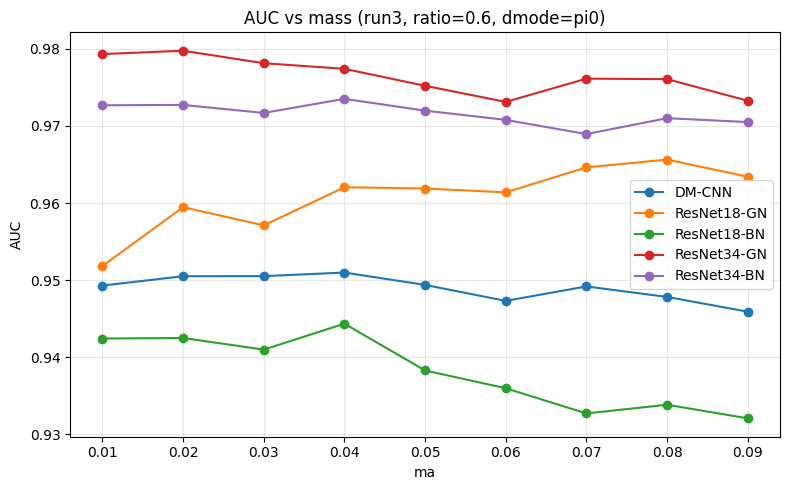

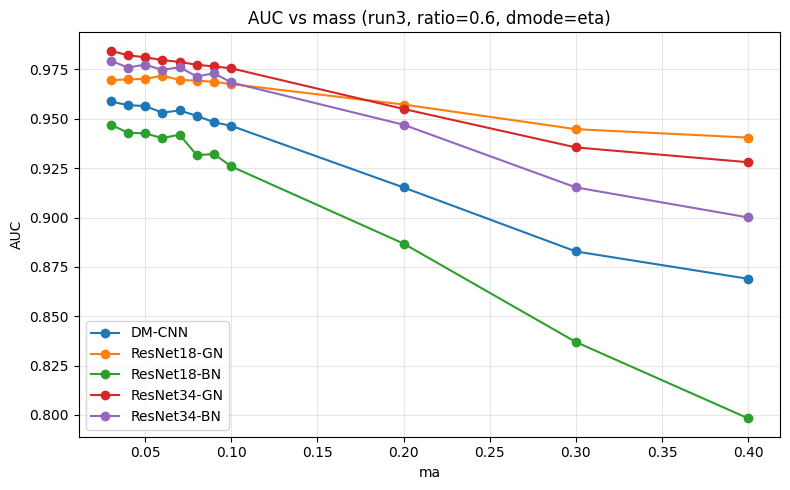

In [5]:
def parse_ratio_mass_dmode(fname):
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

RATIO = 0.6  # or 2.0

# store AUC vs mass separately for pi0 and eta
auc_vs_mass = {
    "pi0": {m: [] for m in MODELS.keys()},
    "eta": {m: [] for m in MODELS.keys()},
}
masses = {"pi0": [], "eta": []}

sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# collect (mass, filename) per dmode for the chosen ratio
sig_by_mode = {"pi0": [], "eta": []}
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if abs(ratio - RATIO) < 1e-9:
        sig_by_mode[dmode].append((mass, f.name))

# sort by mass
for dmode in ["pi0", "eta"]:
    sig_by_mode[dmode] = sorted(sig_by_mode[dmode], key=lambda x: x[0])

# compute AUCs
for dmode in ["pi0", "eta"]:
    for mass, fname in sig_by_mode[dmode]:
        masses[dmode].append(mass)
        for model_name, cfg in MODELS.items():
            f_sig = Path(cfg["sig_dir"]) / fname
            if not f_sig.exists():
                auc_vs_mass[dmode][model_name].append(np.nan)
                continue
            sig = load_scores_csv(f_sig, score_col=SCORE_COL)
            _, _, auc_val = compute_roc_auc(bkg_scores[model_name], sig)
            auc_vs_mass[dmode][model_name].append(auc_val)

# plot: pi0 and eta separately
for dmode in ["pi0", "eta"]:
    plt.figure(figsize=(8, 5))
    for model_name in MODELS.keys():
        plt.plot(masses[dmode], auc_vs_mass[dmode][model_name], marker="o", label=model_name)
    plt.xlabel("ma")
    plt.ylabel("AUC")
    plt.title(f"AUC vs mass (run3, ratio={RATIO}, dmode={dmode})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    out_dir = "/home/hep/an1522/dark_tridents_wspace/outputs/roc_auc"
    os.makedirs(out_dir, exist_ok=True)
    
    plt.savefig(
        os.path.join(out_dir, f"AUC_ratio_{RATIO}_{dmode}_overall_run3.png"),
        dpi=200,
        bbox_inches="tight",
    )
    
    plt.show()



Found 20 signal files for ratio=0.6


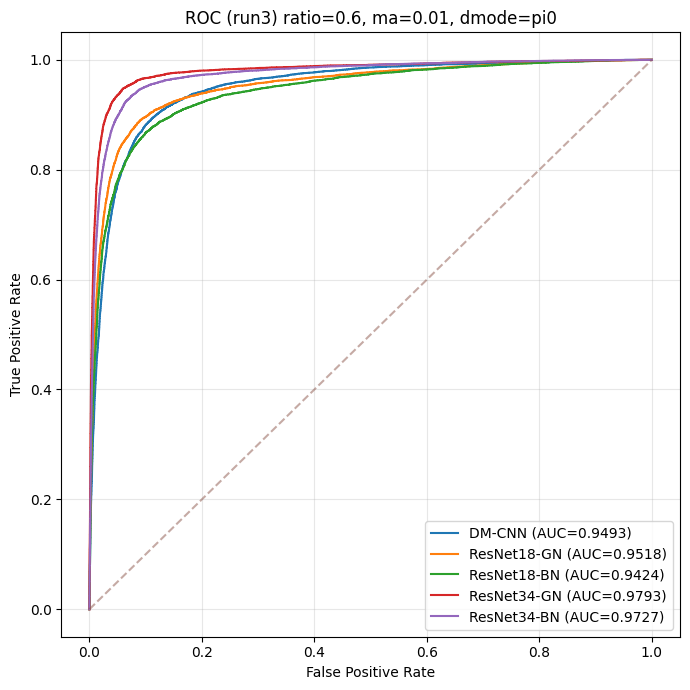

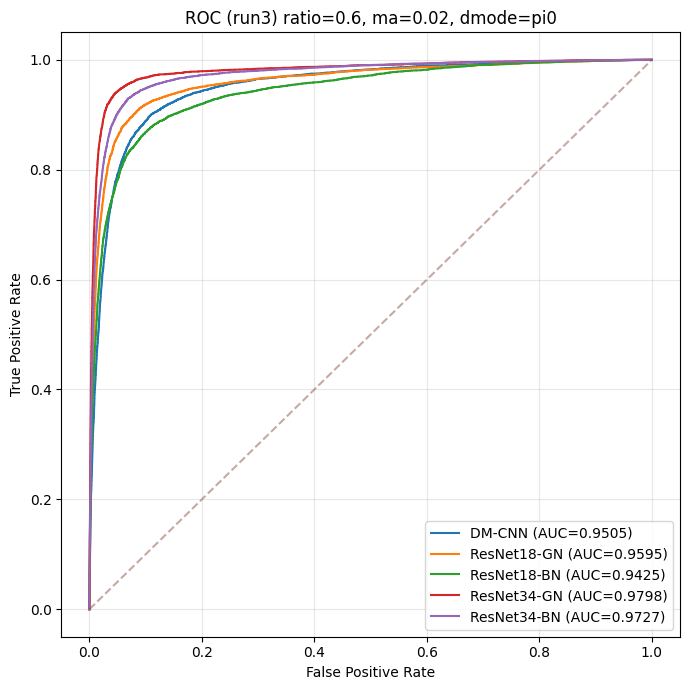

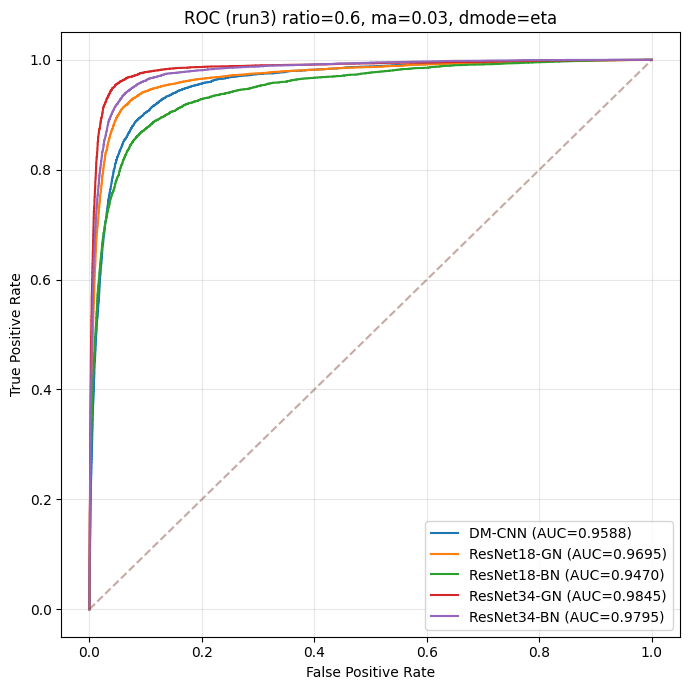

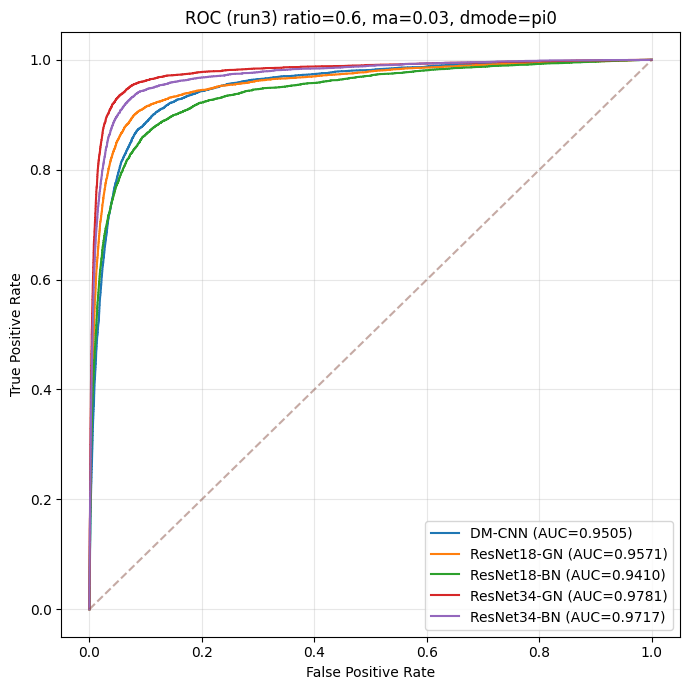

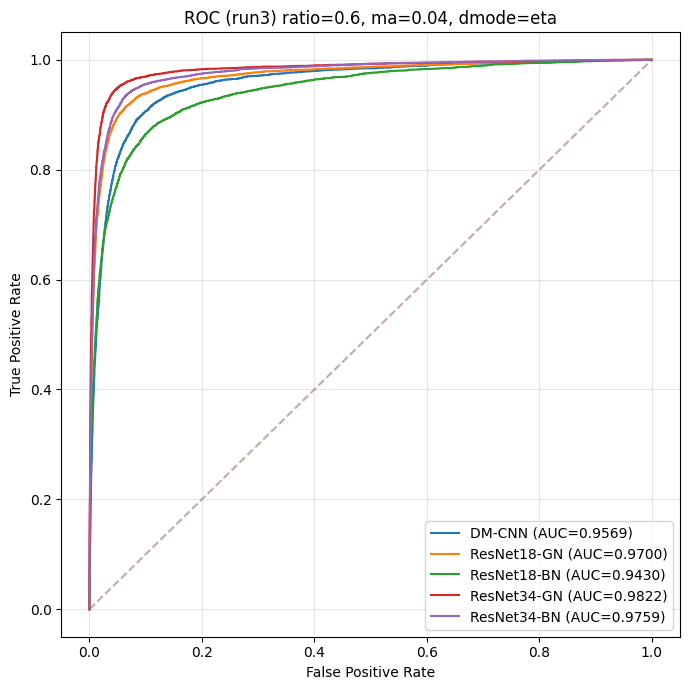

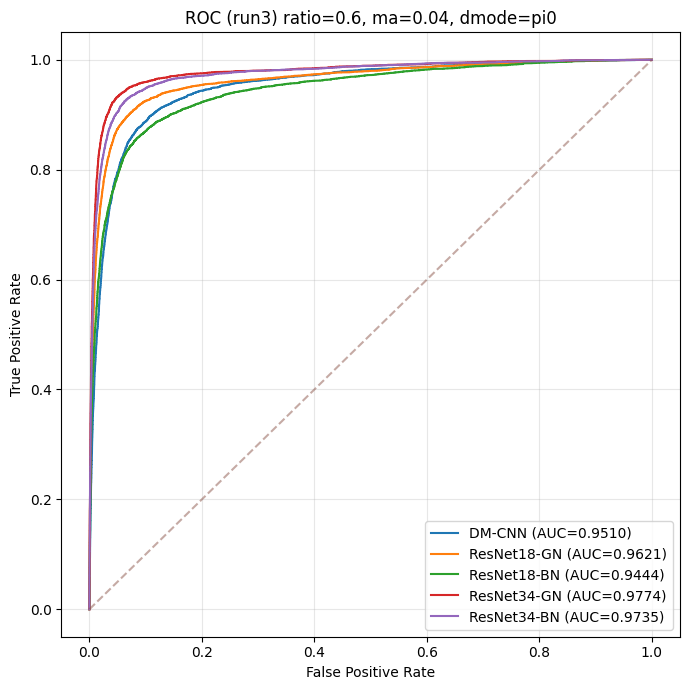

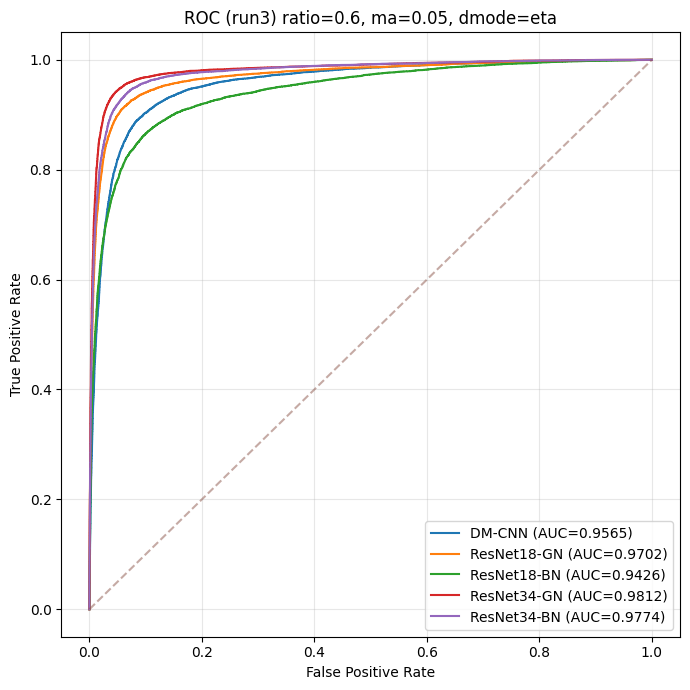

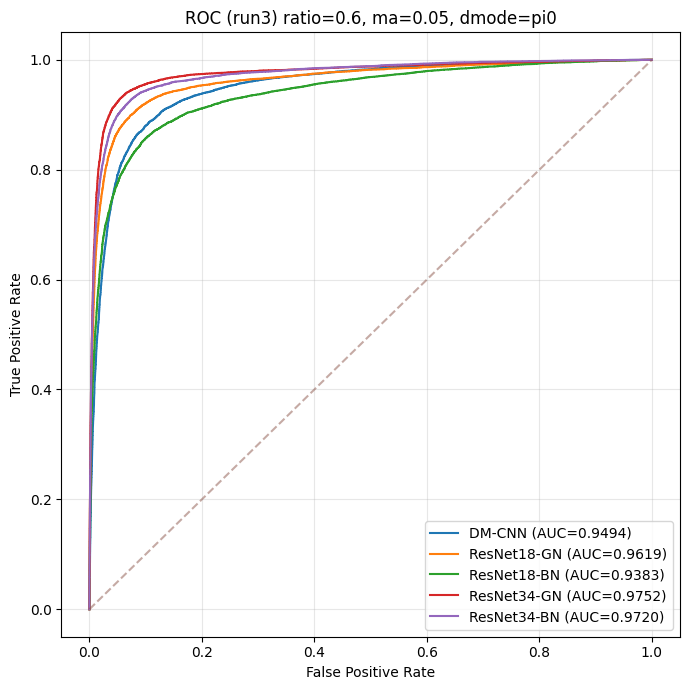

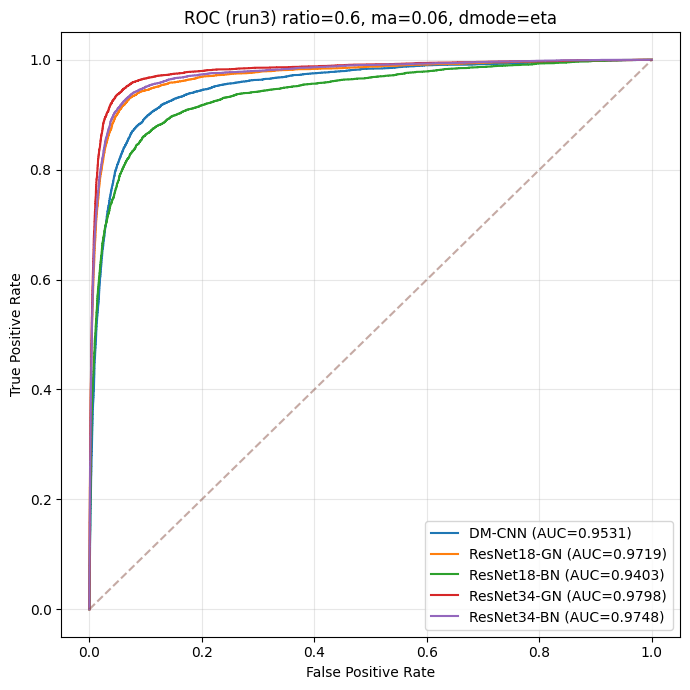

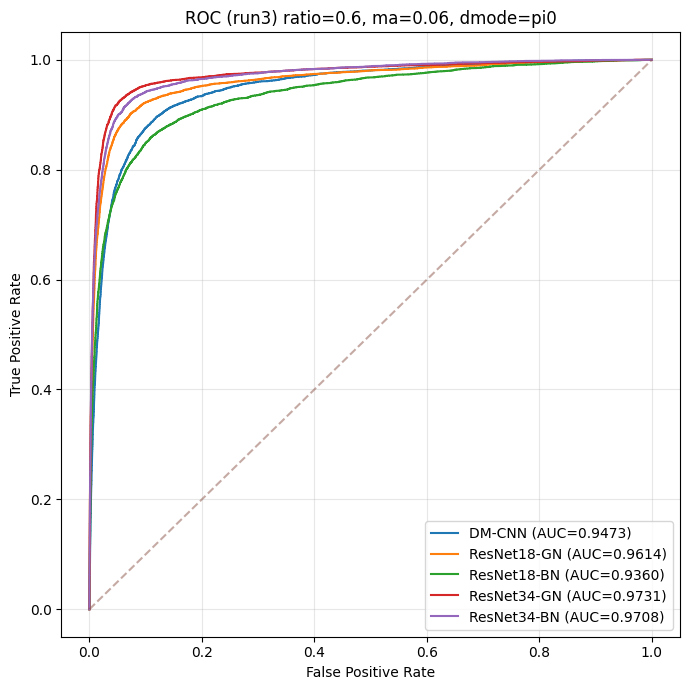

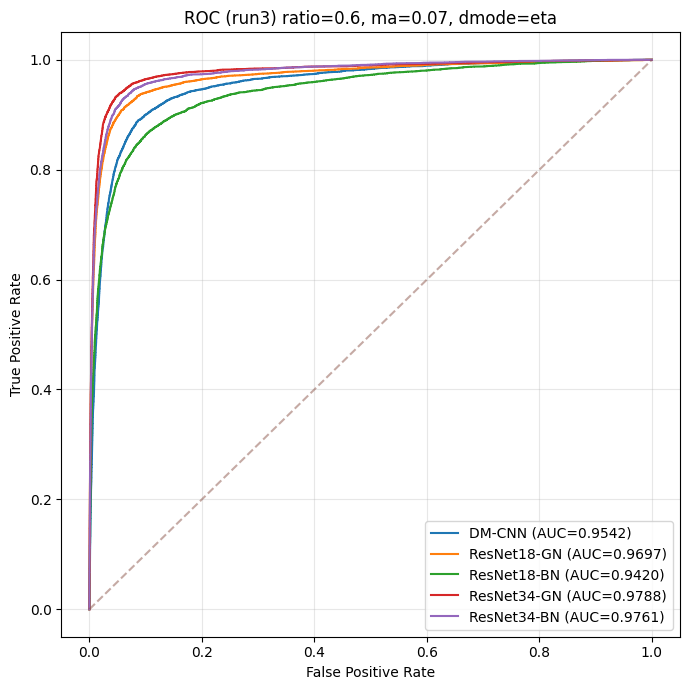

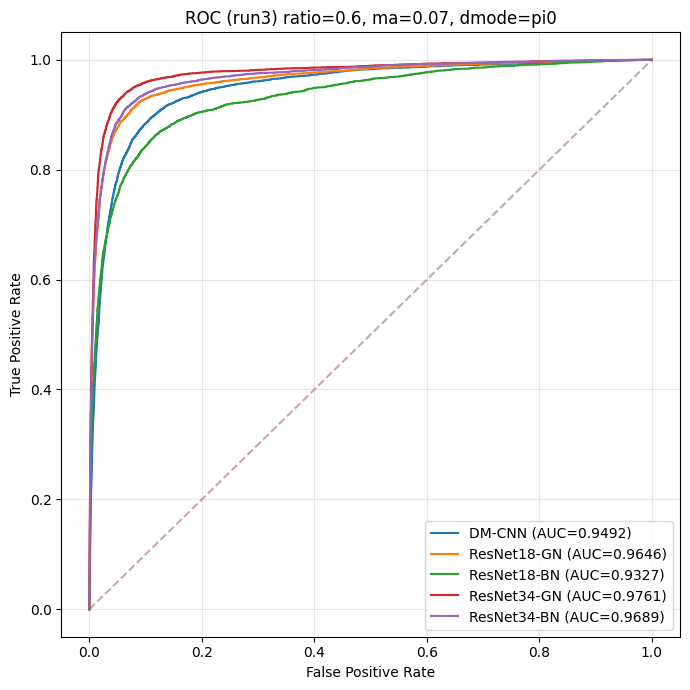

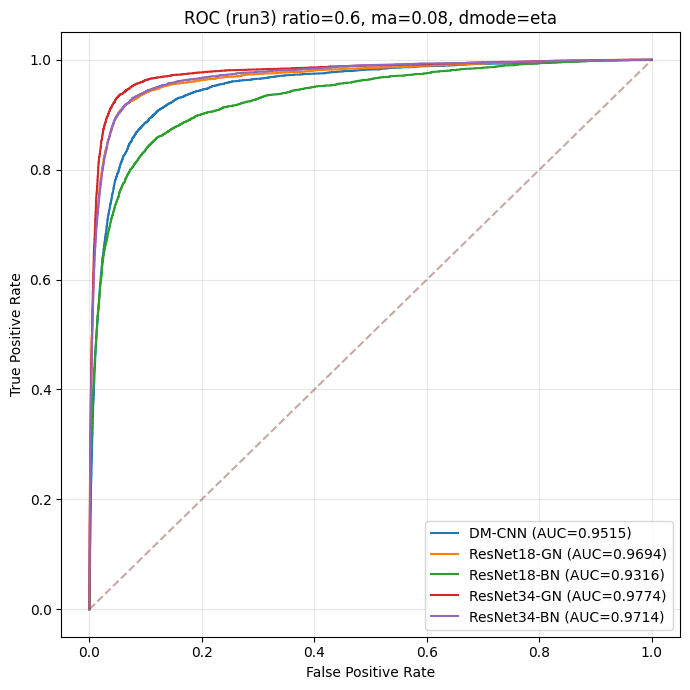

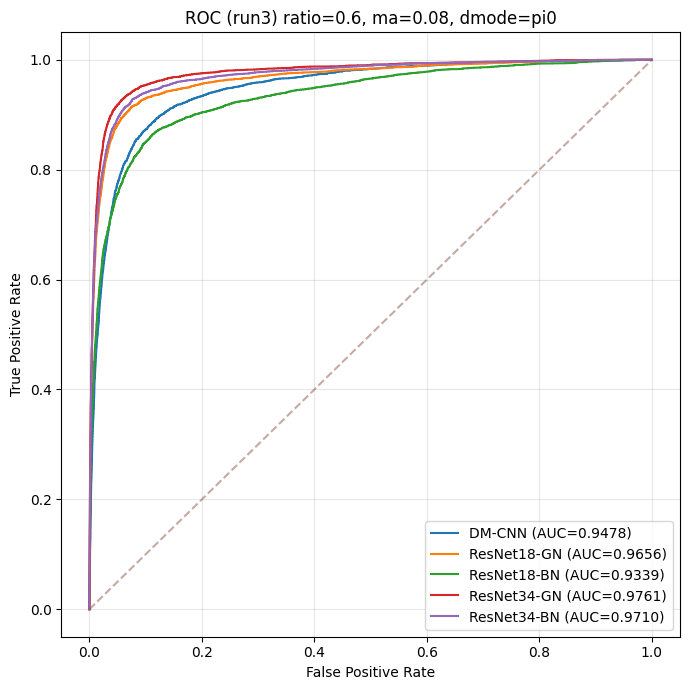

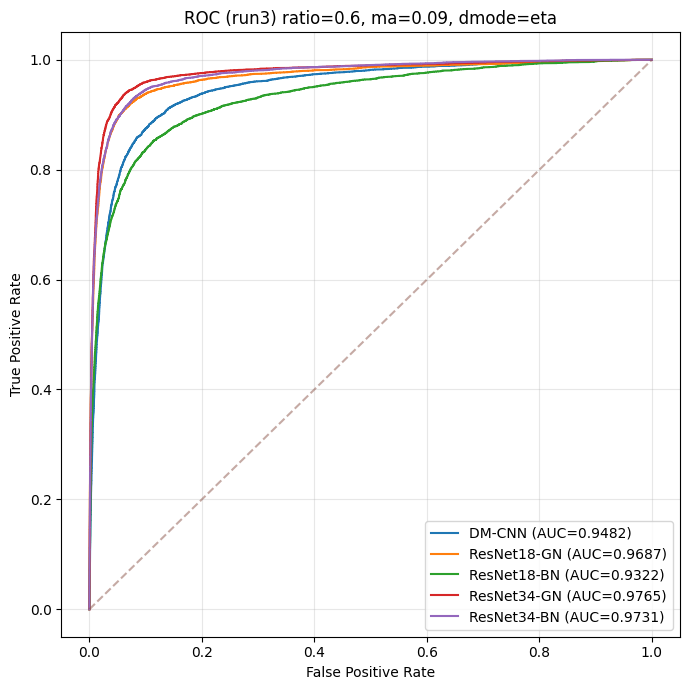

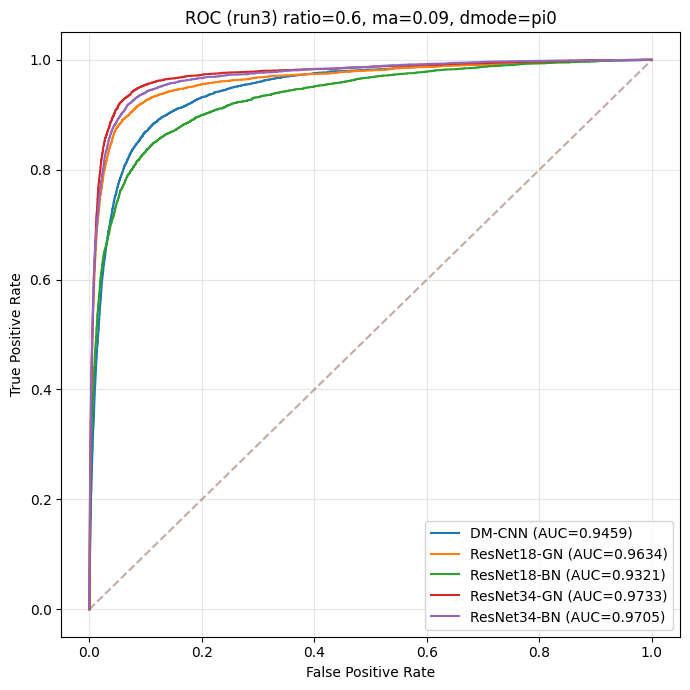

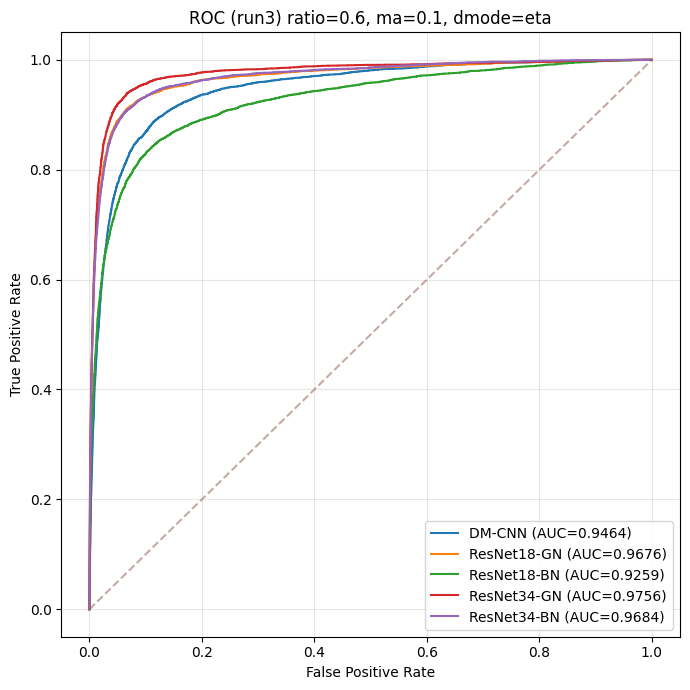

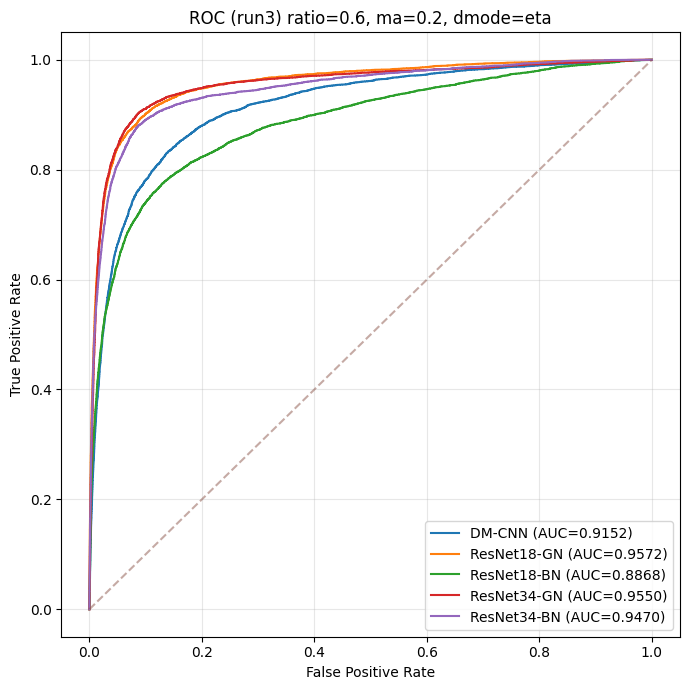

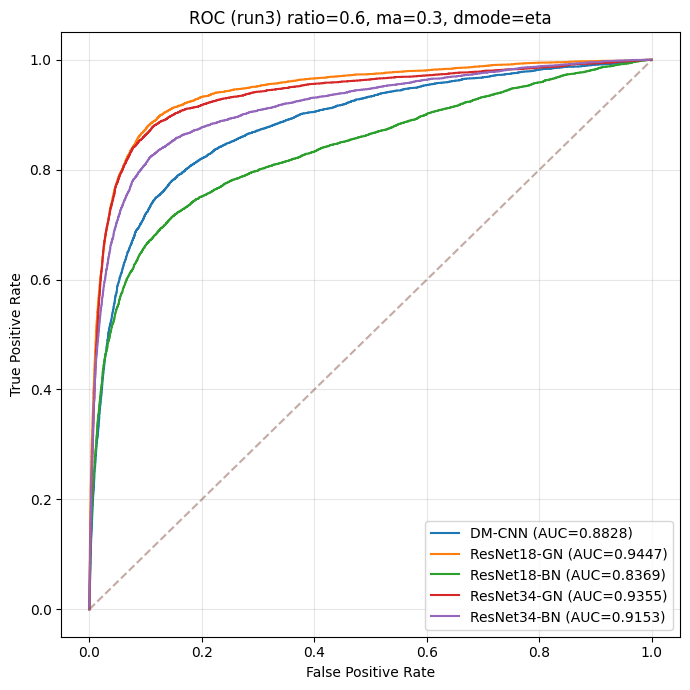

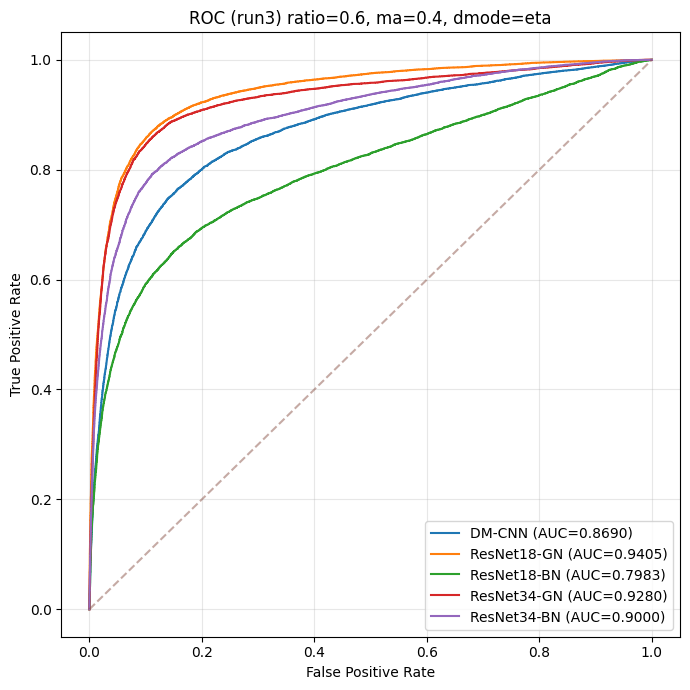

In [6]:
# Parse ratio, mass, and dmode (pi0/eta) from filename
def parse_ratio_mass_dmode(fname):
    # example: run1_dt_ratio_0.6_ma_0.01_pi0_larcv_cropped_scores.csv
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

RATIO = 0.6  # or 2.0

# collect signal files for DM-CNN folder (use that as the "list of mass points")
sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# filter to ratio and keep (mass, dmode, file)
sig_files_ratio = []
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if abs(ratio - RATIO) < 1e-9:
        sig_files_ratio.append((mass, dmode, f))

sig_files_ratio = sorted(sig_files_ratio, key=lambda x: (x[0], x[1]))
print(f"Found {len(sig_files_ratio)} signal files for ratio={RATIO}")

# One figure per mass+dmode, comparing models
for mass, dmode, f_dmcnn in sig_files_ratio:
    plt.figure(figsize=(7, 7))

    for model_name, cfg in MODELS.items():
        # pick the matching signal file name in that model's signal dir
        f_sig = Path(cfg["sig_dir"]) / f_dmcnn.name
        if not f_sig.exists():
            print(f"[skip] missing for {model_name}: {f_sig.name}")
            continue

        sig = load_scores_csv(f_sig, score_col=SCORE_COL)
        fpr, tpr, auc_val = compute_roc_auc(bkg_scores[model_name], sig)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.4f})")

    plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC (run3) ratio={RATIO}, ma={mass}, dmode={dmode}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
